In [1]:
import sys
sys.path.append('/home/peng/git/Machine_learning_for_reliability_analysis/Preprocess')
sys.path.append('/home/peng/git/Machine_learning_for_reliability_analysis/DAlgorithms')

import Preprocessdata
import RFclass 

In [2]:
from __future__ import print_function
from __future__ import division

import logging
from sklearn.datasets import make_classification
from sklearn.cross_validation import cross_val_score

from sklearn.ensemble import RandomForestClassifier as RFC


from bayes_opt import BayesianOptimization
from pandas.core.frame import DataFrame
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics.classification import accuracy_score, confusion_matrix, classification_report
from scipy.interpolate import spline
from sklearn import metrics
from sklearn.metrics import accuracy_score

from sklearn.gaussian_process import GaussianProcess
import timeit

import seaborn as sns
from IPython.core.pylabtools import figsize
from scipy.interpolate import spline
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV
import re
from astropy.io.fits.header import Header
from matplotlib.pyplot import xlim

%matplotlib inline

In [3]:

# Load data set and target values
start = timeit.default_timer()

####### Read the source data######################
df =pd.read_csv('Source_Data.csv', header=0)


p= Preprocessdata.standardprocess()

save_path = '/home/peng/git/Machine_learning_for_reliability_analysis/Ensemble/Results/'
result_name = 'rf_auc_10CV_.csv'

#train, trainlabel, test, testlabel = p.scaledivd(df, 0.8)
#print (np.shape(train))

*************************************change*


In [18]:
#### scale the training dataset first and then apply the rules to test set 
train, trainlabel, test, testlabel = p.noscale(df, 1.0)
#train, trainlabel, test, testlabel = p.sep_scale_divd(df, 1.0)
print ('This dataset contains %s samples with %s variables' %(np.shape(train)[0], np.shape(train)[1]))


This dataset contains 160 samples with 12 variables


In [18]:
### try autoencoding here 1. layout of the NN
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 6  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(12,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(12, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)


'''create a separate encoder model:'''
# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)

'''As well as the decoder model:'''

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))


Using Theano backend.
Using gpu device 0: GeForce GTX 980 Ti (CNMeM is enabled with initial size: 35.0% of memory, cuDNN 5005)


In [7]:
#directly use RFC without optimizing parameters(Bayesian optimzation)


bestmodel= RFC(n_estimators = 100).fit(train,trainlabel)
tree_best = 90
feature_best = 0.1
rad_stat = 2

In [19]:
### 2. Optimizer for autoencoding 
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


In [20]:
## 3. train the autoencoder
autoencoder.fit(train, train,
                nb_epoch=200,
                batch_size=32,
                shuffle=True)
                #validation_data=(trainlabel, trainlabel))


Epoch 1/200
128/128 [==============================] - 0s - loss: 0.7184     
Epoch 2/200
128/128 [==============================] - 0s - loss: 0.7161     
Epoch 3/200
128/128 [==============================] - 0s - loss: 0.7139     
Epoch 4/200
128/128 [==============================] - 0s - loss: 0.7117     
Epoch 5/200
128/128 [==============================] - 0s - loss: 0.7095     
Epoch 6/200
128/128 [==============================] - 0s - loss: 0.7075     
Epoch 7/200
128/128 [==============================] - 0s - loss: 0.7054     
Epoch 8/200
128/128 [==============================] - 0s - loss: 0.7034     
Epoch 9/200
128/128 [==============================] - 0s - loss: 0.7014     
Epoch 10/200
128/128 [==============================] - 0s - loss: 0.6995     
Epoch 11/200
128/128 [==============================] - 0s - loss: 0.6976     
Epoch 12/200
128/128 [==============================] - 0s - loss: 0.6958     
Epoch 13/200
128/128 [==============================] - 0s - 

In [21]:
# 4. Reconstruct the train
encoded_train = encoder.predict(train)
decoded_train = decoder.predict(encoded_train)
train = decoded_train

In [22]:
# 4. Reconstruct the test
encoded_test = encoder.predict(test)
decoded_test = decoder.predict(encoded_test)
test = decoded_test

In [23]:
print (np.shape(train))
print (np.shape(test))


(128, 12)
(32, 12)


In [24]:
print (np.mean(testlabel))

0.5


In [25]:
#define the BO function
seed = 'rf'
rad_stat = 2

def rfccv(n_estimators, max_features):
    return cross_val_score(RFC(n_estimators=int(n_estimators),                               
                               max_features=min(max_features, 0.999),
                               random_state=2),
                           train, trainlabel, 'roc_auc', cv=10, n_jobs = -1).mean()

In [26]:
rfcBO = BayesianOptimization(rfccv, {'n_estimators': (64, 128),                                         
                                         'max_features': (0.1, 0.999)})
rfcBO.maximize()

print('Final Results')
print('RF: %f' % rfcBO.res['max']['max_val'])

Initialization
---------------------------------------------------------------
 Step |   Time |      Value |   max_features |   n_estimators | 
    1 | 00m00s |    0.81437 |         0.4089 |       104.4793 | 
    2 | 00m00s |    0.77971 |         0.8380 |        75.5756 | 
    3 | 00m00s |    0.82168 |         0.1061 |       106.5872 | 
    4 | 00m00s |    0.80241 |         0.6491 |       104.0028 | 
    5 | 00m00s |    0.79555 |         0.7362 |        96.0460 | 
Bayesian Optimization
---------------------------------------------------------------
 Step |   Time |      Value |   max_features |   n_estimators | 
    6 | 00m04s |    0.80584 |         0.2064 |       111.3557 | 
    7 | 00m01s |    0.81964 |         0.1568 |       104.3905 | 
    8 | 00m02s |    0.81066 |         0.2014 |       106.3771 | 
    9 | 00m02s |    0.81482 |         0.1000 |       101.1747 | 
   10 | 00m02s |    0.81862 |         0.1000 |       111.4043 | 
   11 | 00m01s |    0.80575 |         0.4077 |        9

In [27]:
# use exploration to get better results
import random
from operator import add, sub

ops = (add, sub)
op = random.choice(ops)

tree_best = np.int(rfcBO.res['max']['max_params']['n_estimators'])
feature_best= np.float(rfcBO.res['max']['max_params']['max_features'])

new_tree_points, new_feature_points = [],[]

for i in xrange(0,5):
    new_tree_points.append(op(tree_best, tree_best*0.1*i) )
    new_feature_points.append(op(feature_best, feature_best*0.1*i) )



#new_feature_points = np.linspace(feature_best/2, feature_best*1.5, num = len(new_tree_points))
#new_feature_points.append(feature_best)

rfcBO_new = BayesianOptimization(rfccv, {'n_estimators': (64, 128),                                         
                                         'max_features': (0.1, 0.999)})
rfcBO_new.explore({'n_estimators': new_tree_points, 'max_features': new_feature_points})


rfcBO_new.maximize()

print('Final Results')
print('RF: %f' % rfcBO_new.res['max']['max_val'])


Initialization
---------------------------------------------------------------
 Step |   Time |      Value |   max_features |   n_estimators | 
    1 | 00m00s |    0.82168 |         0.1061 |       106.0000 | 
    2 | 00m00s |    0.80788 |         0.0955 |        95.4000 | 
    3 | 00m00s |    0.80604 |         0.0849 |        84.8000 | 
    4 | 00m00s |    0.81196 |         0.0743 |        74.2000 | 
    5 | 00m00s |    0.81241 |         0.0637 |        63.6000 | 
    6 | 00m00s |    0.80363 |         0.4088 |        76.3116 | 
    7 | 00m00s |    0.80825 |         0.7660 |       114.3030 | 
    8 | 00m00s |    0.81298 |         0.3541 |        97.3486 | 
    9 | 00m00s |    0.79824 |         0.7472 |       111.7140 | 
   10 | 00m00s |    0.80862 |         0.7668 |        98.4975 | 
Bayesian Optimization
---------------------------------------------------------------
 Step |   Time |      Value |   max_features |   n_estimators | 
   11 | 00m05s |    0.80927 |         0.1061 |       11

In [28]:
# get the best parameters for plotting auc on training and test
if (1): ### True use the above best parameters, false use the recored best set
    tree_best = np.int(rfcBO_new.res['max']['max_params']['n_estimators'])
    feature_best= np.float(rfcBO_new.res['max']['max_params']['max_features'])
    print ('use the latest records')

else:
    tree_best = np.int(70.3800)
    feature_best=0.7260
    print ('use the historical records')


bestmodel= RFC(n_estimators = tree_best, max_features = feature_best).fit(train,trainlabel)

print (tree_best, feature_best)

use the latest records
106 0.106105751518


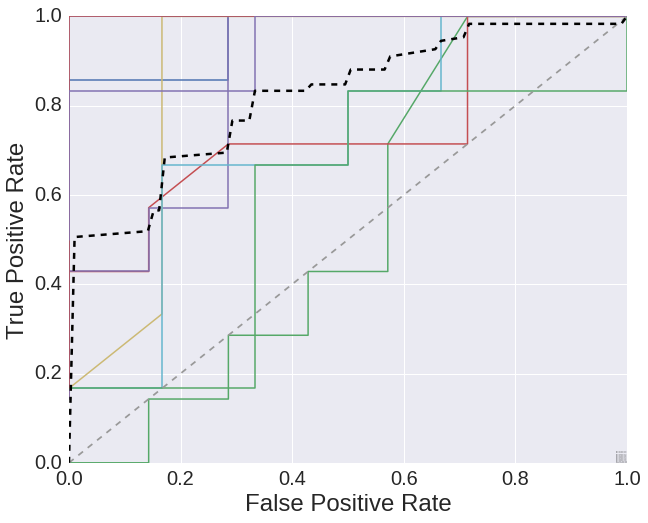

In [46]:
#use the best parameters to plot cv auc on the training set
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold
from scipy import interp

figsize(10,8)
cv = StratifiedKFold(trainlabel, n_folds=10)

bestmodel_training= RFC(n_estimators = tree_best, max_features = feature_best, 
                            random_state = rad_stat)
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (training, testing) in enumerate(cv):
    probas_ = bestmodel_training.fit(train[training], trainlabel[training]).predict_proba(train[testing])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(trainlabel[testing], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1.5, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', 
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2.5)

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate',fontsize = 24)
plt.ylabel('True Positive Rate',fontsize = 24)
plt.xticks(fontsize = 20) 

plt.yticks(fontsize = 20) 

#plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right",fontsize = 0.1)

#plt.fill_between(mean_fpr, 0, mean_tpr, #color="#348ABD", 
                # color="#66cdaa", alpha=0.15)
plt.show()

In [30]:
#predict the test set

tt=RFclass.test()

result = tt.testforest_score(test, testlabel,bestmodel)
print (result)

*******************************************
[[11  5]
 [ 3 13]]


*******************************************


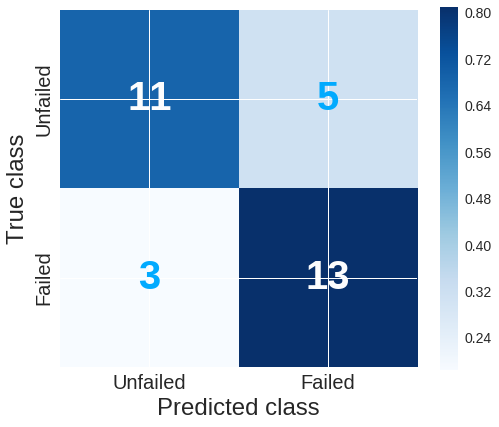

In [31]:
#plot the confusion matrix on test set
import Superplot
from sklearn.metrics.classification import accuracy_score, confusion_matrix, classification_report

pp = Superplot.fancy()
pp.plot_confusion_matrix(result)

In [32]:
#plot the auc on test set
from sklearn.metrics import roc_curve, auc

y_score = bestmodel.predict_proba(test)
#print (y_score)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

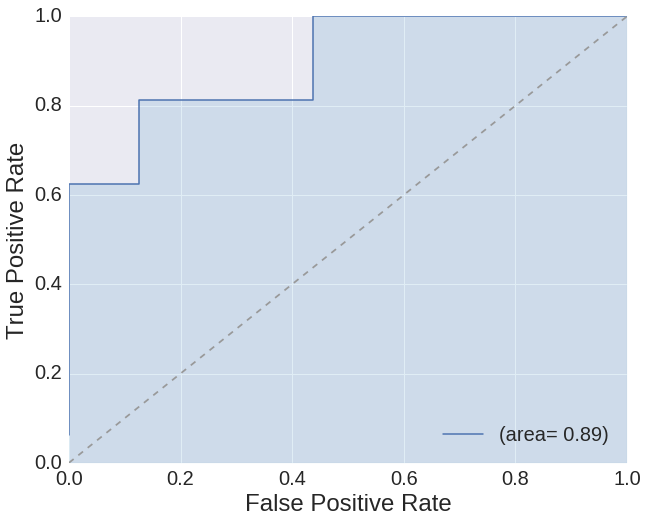

In [33]:
#plot the auc on test set
fpr, tpr, thresholds = roc_curve(testlabel, y_score[:, 1])
roc_auc = auc(fpr, tpr)

figsize(10,8)

plt.plot(fpr, tpr, lw=1.5, label='(area= %0.2f)' % ( roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
#plt.xlim([-0.05, 1.05])
#plt.ylim([-0.05, 1.05])

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.xlabel('False Positive Rate',fontsize = 24)
plt.ylabel('True Positive Rate',fontsize = 24)
plt.xticks(fontsize = 20) 

plt.yticks(fontsize = 20) 

#plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right",fontsize = 20)
sec = np.arange(0.0, 1.0, 0.05)
plt.fill_between(fpr, 0, tpr, color="#348ABD", alpha=0.15)
plt.show()

This is for training set**************************************
************************this is the output of relative importance**************
[ 9  6  2  4 11  3  5  7 10  1  8  0]
Feature ranking:
1. feature 9 (0.110713)
2. feature 6 (0.096155)
3. feature 2 (0.095023)
4. feature 4 (0.088546)
5. feature 11 (0.085650)
6. feature 3 (0.085330)
7. feature 5 (0.084459)
8. feature 7 (0.078074)
9. feature 10 (0.071712)
10. feature 1 (0.071549)
11. feature 8 (0.067358)
12. feature 0 (0.065430)


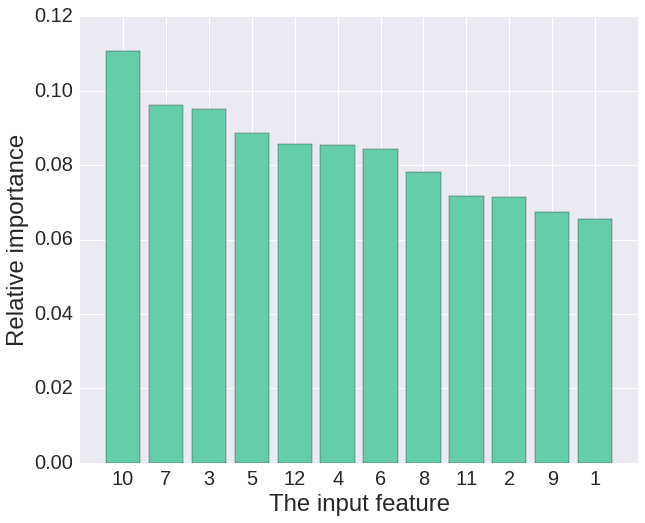

In [34]:
ff= RFclass.training()
ff.importance(bestmodel, 12, color = '#66cdaa', plot_std = False)


In [35]:
yy = pd.read_csv(save_path + 'auc_compare.csv', header = 0)

print (yy)

    Unnamed: 0    y_weak
0            0  0.380165
1            1  0.082645
2            2  0.876033
3            3  0.421488
4            4  0.950413
5            5  0.561983
6            6  1.000000
7            7  0.735537
8            8  0.991736
9            9  0.074380
10          10  0.561983
11          11  0.033058
12          12  0.652893
13          13  0.933884
14          14  0.727273
15          15  0.132231
16          16  0.677686
17          17  0.388430
18          18  0.107438
19          19  0.504132
20          20  0.876033
21          21  0.181818
22          22  0.900826
23          23  0.033058
24          24  0.685950
25          25  0.297521
26          26  0.545455
27          27  0.876033
28          28  0.471074
29          29  0.413223
30          30  0.553719
31          31  0.024793


In [37]:
yy['y_strong']=y_score[:,1]
yy.to_csv(save_path + 'y_compare_new.csv', header = True)

In [38]:
fpr_, tpr_, thresholds_ = roc_curve(testlabel, yy['y_weak'])

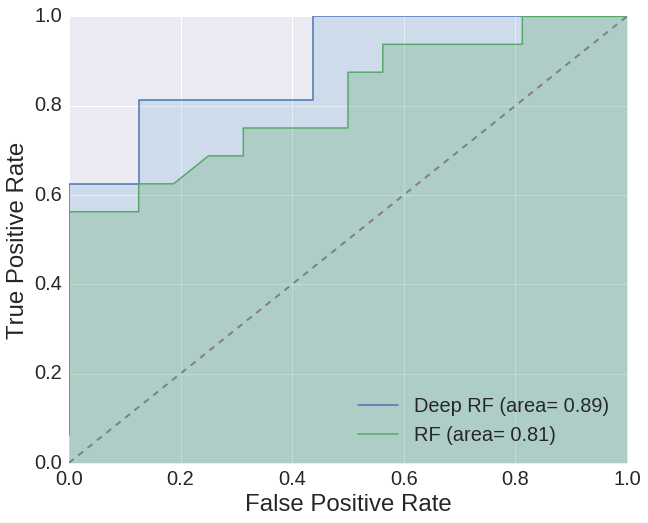

In [41]:
#plot the auc on test set
fpr, tpr, thresholds = roc_curve(testlabel, y_score[:, 1])



roc_auc = auc(fpr, tpr)


figsize(10,8)

plt.plot(fpr, tpr, lw=1.5, label='Deep RF (area= %0.2f)' % ( roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
#plt.xlim([-0.05, 1.05])
#plt.ylim([-0.05, 1.05])

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.xlabel('False Positive Rate',fontsize = 24)
plt.ylabel('True Positive Rate',fontsize = 24)
plt.xticks(fontsize = 20) 

plt.yticks(fontsize = 20) 

#plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right",fontsize = 20)
sec = np.arange(0.0, 1.0, 0.05)
plt.fill_between(fpr, 0, tpr, color="#348ABD", alpha=0.15)

#######################
fpr_, tpr_, thresholds_ = roc_curve(testlabel, yy['y_weak'])
roc_auc_ = auc(fpr_, tpr_)

plt.plot(fpr_, tpr_, lw=1.5, label='RF (area= %0.2f)' % ( roc_auc_))
plt.plot([0, 1], [0, 1], '--', color=(0.5, 0.5, 0.5))
plt.legend(loc="lower right",fontsize = 20)
sec = np.arange(0.0, 1.0, 0.05)
plt.fill_between(fpr_, 0, tpr_, color="g", alpha=0.15)




plt.show()

In [42]:
print (df)

     Length of roadway (m)  Dripper flow rate  age of bolts at survey  \
0                        5               0.00                      11   
1                        5              12.30                      10   
2                       35               0.00                       8   
3                        5               0.00                       7   
4                       30               0.00                       9   
5                       58               0.00                       9   
6                       65               0.00                      11   
7                        5               0.00                       7   
8                       18               0.00                      10   
9                       25               0.00                      11   
10                      35               0.00                      11   
11                      65              12.30                       2   
12                       5               0.00      

In [47]:
from sklearn.decomposition import PCA

for i in np.arange(1,13,1):

    pca = PCA(n_components=i)
    newtrain=pca.fit_transform(train)
    print (pca.explained_variance_ratio_)
    print (np.sum(pca.explained_variance_ratio_))
    print (np.shape(newtrain))

[ 0.75020047]
0.750200465818
(128, 1)
[ 0.75020047  0.15009109]
0.900291553027
(128, 2)
[ 0.75020047  0.15009109  0.06093892]
0.961230472545
(128, 3)
[ 0.75020047  0.15009109  0.06093892  0.02378999]
0.985020458741
(128, 4)
[ 0.75020047  0.15009109  0.06093892  0.02378999  0.00867139]
0.993691846287
(128, 5)
[ 0.75020047  0.15009109  0.06093892  0.02378999  0.00867139  0.00355781]
0.997249653449
(128, 6)
[ 0.75020047  0.15009109  0.06093892  0.02378999  0.00867139  0.00355781
  0.00179922]
0.999048868929
(128, 7)
[  7.50200466e-01   1.50091087e-01   6.09389195e-02   2.37899862e-02
   8.67138755e-03   3.55780716e-03   1.79921548e-03   5.92844189e-04]
0.999641713119
(128, 8)
[  7.50200466e-01   1.50091087e-01   6.09389195e-02   2.37899862e-02
   8.67138755e-03   3.55780716e-03   1.79921548e-03   5.92844189e-04
   1.60985304e-04]
0.999802698423
(128, 9)
[  7.50200466e-01   1.50091087e-01   6.09389195e-02   2.37899862e-02
   8.67138755e-03   3.55780716e-03   1.79921548e-03   5.92844189e-04